In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
df_charging = pd.read_csv('/content/drive/MyDrive/VIU/TFM/dataset/Dataset 1_EV charging reports.csv', sep=';')
df_traffic = pd.read_csv('/content/drive/MyDrive/VIU/TFM/dataset/Dataset 6_Local traffic distribution.csv', sep=';')
df_weather = pd.read_csv('/content/drive/MyDrive/VIU/TFM/dataset/Norway_Trondheim_ExactLoc_Weather.csv')

# Eliminar columna innecesaria de df_weather
if 'Unnamed: 0' in df_weather.columns:
    df_weather = df_weather.drop('Unnamed: 0', axis=1)

In [5]:
df_charging.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


In [6]:
print("\ndf_charging information:")
print(df_charging.info())
print("\ndf_charging duplicated elements: ", df_charging.duplicated().sum())


df_charging information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_ID         6878 non-null   int64  
 1   Garage_ID          6878 non-null   object 
 2   User_ID            6878 non-null   object 
 3   User_type          6878 non-null   object 
 4   Shared_ID          1412 non-null   object 
 5   Start_plugin       6878 non-null   object 
 6   Start_plugin_hour  6878 non-null   int64  
 7   End_plugout        6844 non-null   object 
 8   End_plugout_hour   6844 non-null   float64
 9   El_kWh             6878 non-null   object 
 10  Duration_hours     6844 non-null   object 
 11  month_plugin       6878 non-null   object 
 12  weekdays_plugin    6878 non-null   object 
 13  Plugin_category    6878 non-null   object 
 14  Duration_category  6844 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usa

In [7]:
# Estadísticas descriptivas
print(df_charging.describe())

        session_ID  Start_plugin_hour  End_plugout_hour
count  6878.000000        6878.000000       6844.000000
mean   3439.500000          16.325240         12.546902
std    1985.651908           4.363108          5.256756
min       1.000000           0.000000          0.000000
25%    1720.250000          15.000000          7.000000
50%    3439.500000          17.000000         12.000000
75%    5158.750000          19.000000         17.000000
max    6878.000000          23.000000         23.000000


##Limpieza de datos

In [8]:
# Convertir Start/End_plugin a tipo datetime
df_charging['Start_plugin'] = pd.to_datetime(df_charging['Start_plugin'], format="%d.%m.%Y %H:%M")
df_charging['End_plugout'] = pd.to_datetime(df_charging['End_plugout'], format="%d.%m.%Y %H:%M", errors='coerce')

In [9]:
# Reemplazar ',' por '.' en las columnas correspondientes
df_charging['El_kWh'] = df_charging['El_kWh'].str.replace(',', '.').astype(float)
df_charging['Duration_hours'] = df_charging['Duration_hours'].str.replace(',', '.').astype(float)

In [10]:
# Verificar valores únicos en columnas categóricas
for col in ['User_type', 'month_plugin', 'weekdays_plugin', 'Plugin_category', 'Duration_category']:
    print(f"{col}: {df_charging[col].unique()}")

User_type: ['Private' 'Shared']
month_plugin: ['Dec' 'Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov']
weekdays_plugin: ['Friday' 'Saturday' 'Monday' 'Tuesday' 'Wednesday' 'Sunday' 'Thursday']
Plugin_category: ['late morning (9-12)' 'late afternoon (15-18)'
 'late evening (21-midnight)' 'early evening (18-21)'
 'early morning (6-9)' 'early afternoon (12-15)'
 'early night (midnight-3)' 'late night (3-6)']
Duration_category: ['Less than 3 hours' 'Between 6 and 9  hours' 'More than 18 hours'
 'Between 3 and 6 hours' 'Between 15 and 18 hours'
 'Between 12 and 15 hours' 'Between 9 and 12 hours' nan]


In [11]:
# Función para detectar outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Outliers en El_kWh y Duration_hours
outliers_kwh = detect_outliers(df_charging, 'El_kWh')
outliers_duration = detect_outliers(df_charging, 'Duration_hours')

print(f"\nOutliers El_kWh: {len(outliers_kwh)} valores")
print(f"Outliers Duration_hours: {len(outliers_duration)} valores")


Outliers El_kWh: 457 valores
Outliers Duration_hours: 314 valores


## Análisis Univariante

###Variables Numericas

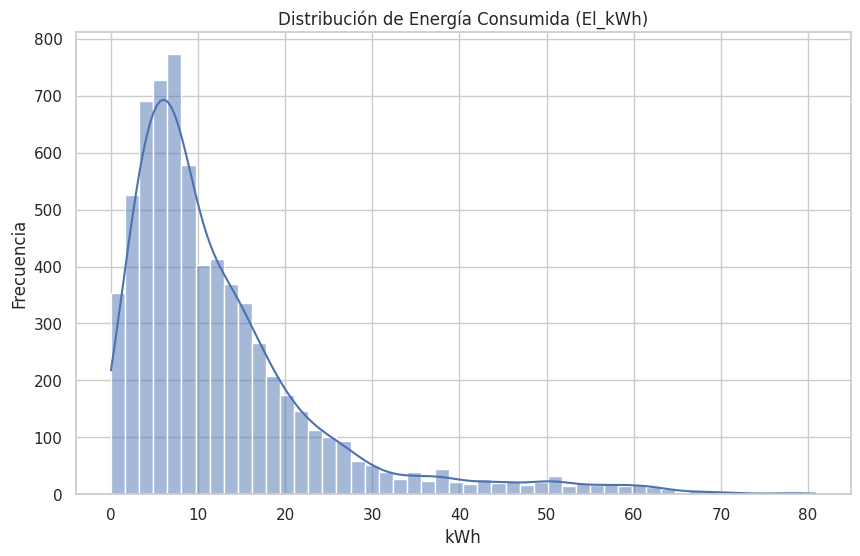

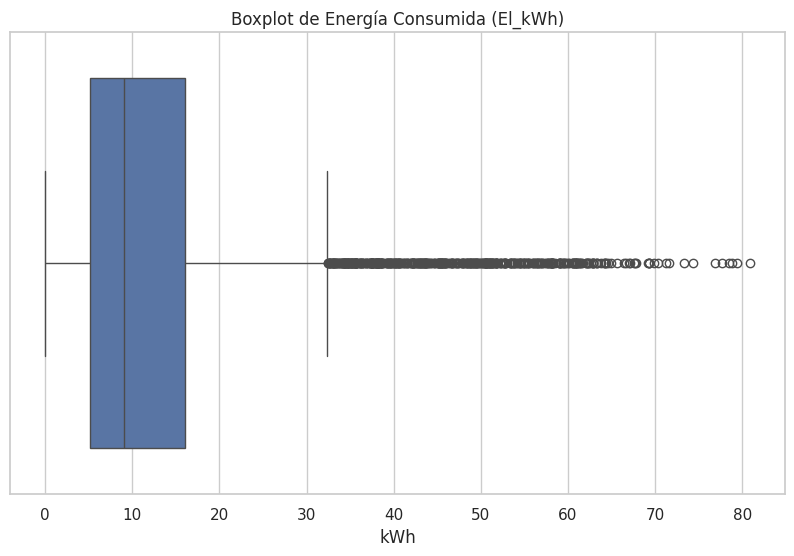

In [12]:
# El_kWh (Energía consumida):
plt.figure(figsize=(10, 6))
sns.histplot(df_charging['El_kWh'], bins=50, kde=True)
plt.title('Distribución de Energía Consumida (El_kWh)')
plt.xlabel('kWh')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_charging['El_kWh'])
plt.title('Boxplot de Energía Consumida (El_kWh)')
plt.xlabel('kWh')
plt.show()

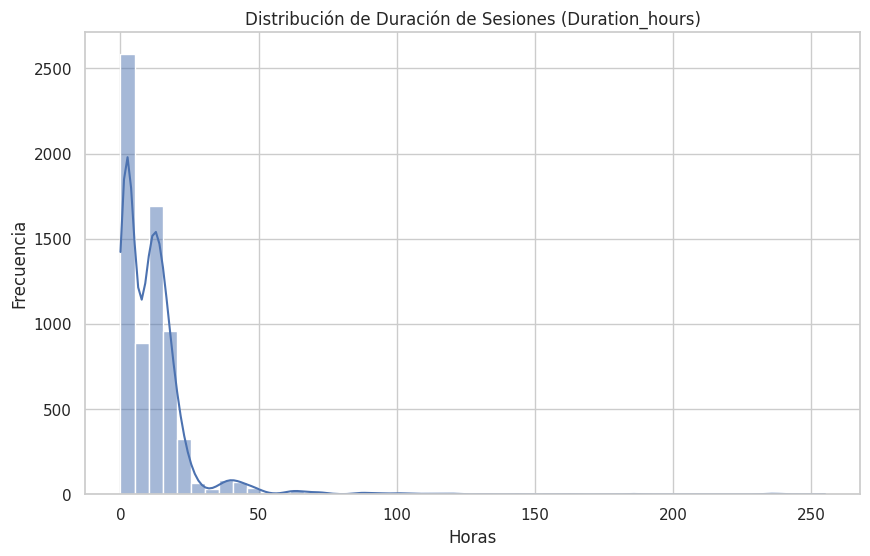

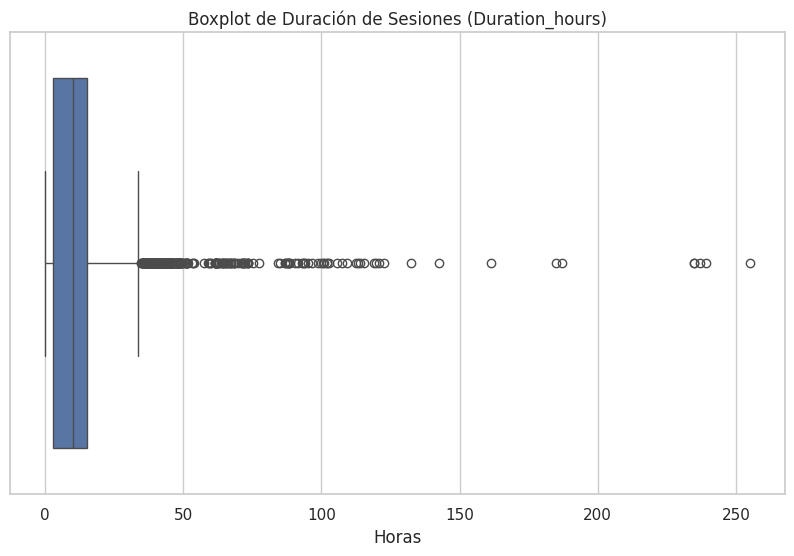

In [13]:
# Duration_hours (Duración de la sesión)
plt.figure(figsize=(10, 6))
sns.histplot(df_charging['Duration_hours'], bins=50, kde=True)
plt.title('Distribución de Duración de Sesiones (Duration_hours)')
plt.xlabel('Horas')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_charging['Duration_hours'])
plt.title('Boxplot de Duración de Sesiones (Duration_hours)')
plt.xlabel('Horas')
plt.show()

###Variables Categóricas

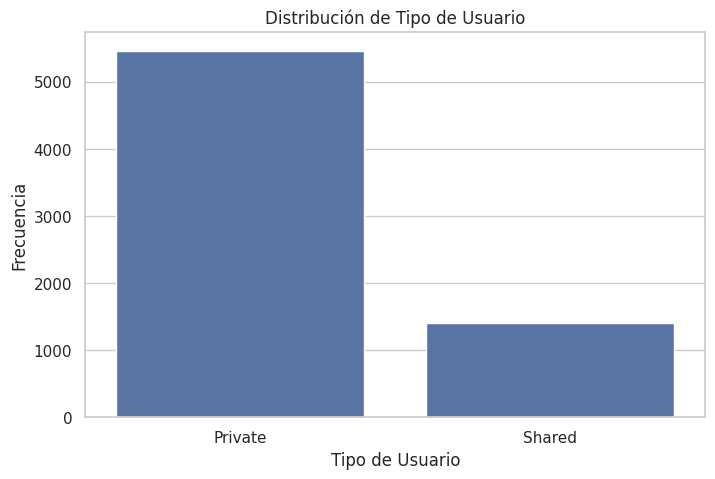

In [14]:
# User_type
plt.figure(figsize=(8, 5))
sns.countplot(x='User_type', data=df_charging)
plt.title('Distribución de Tipo de Usuario')
plt.xlabel('Tipo de Usuario')
plt.ylabel('Frecuencia')
plt.show()

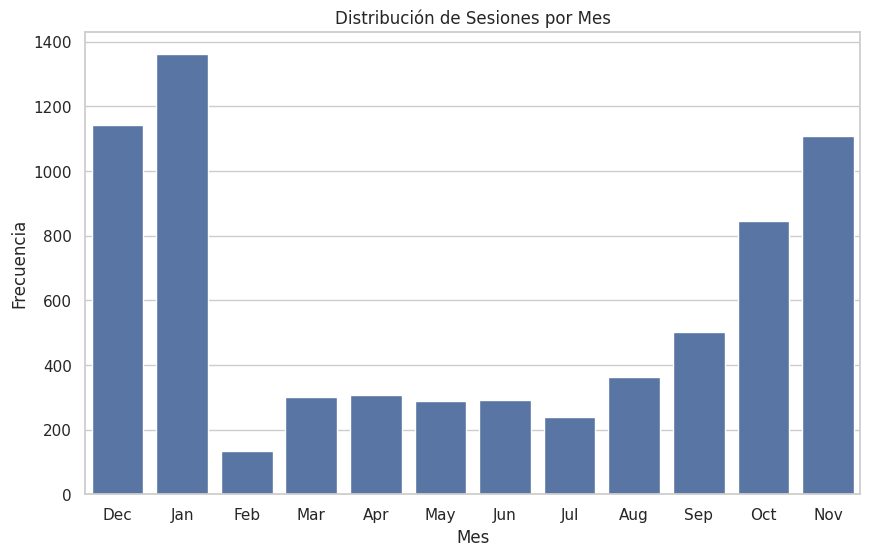

In [15]:
# month_plugin
plt.figure(figsize=(10, 6))
sns.countplot(x='month_plugin', data=df_charging)
plt.title('Distribución de Sesiones por Mes')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.show()

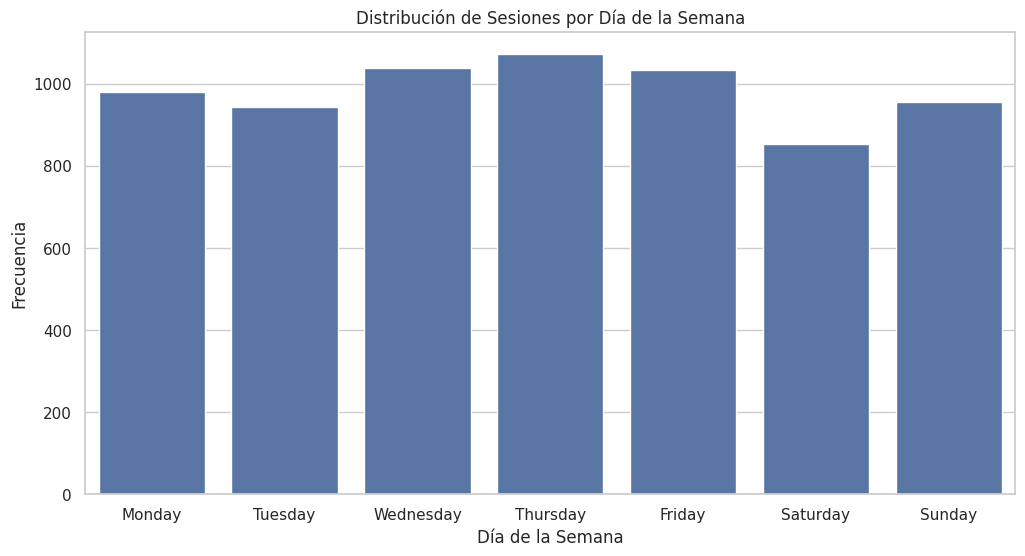

In [16]:
# weekdays_plugin
plt.figure(figsize=(12, 6))
sns.countplot(x='weekdays_plugin', data=df_charging, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribución de Sesiones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia')
plt.show()

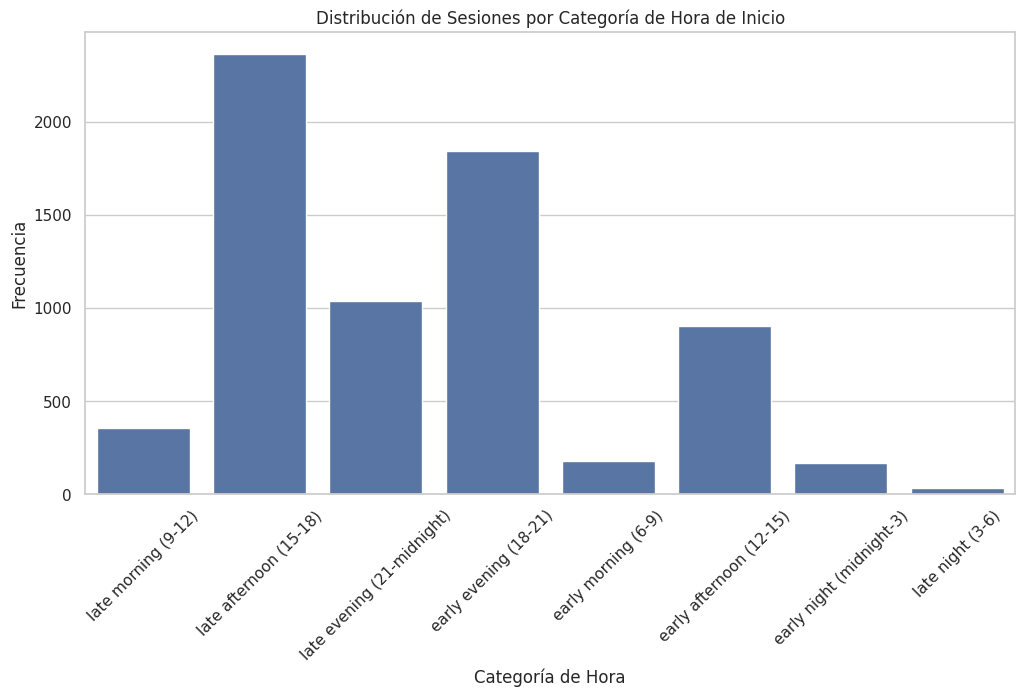

In [17]:
# Plugin_category
plt.figure(figsize=(12, 6))
sns.countplot(x='Plugin_category', data=df_charging)
plt.title('Distribución de Sesiones por Categoría de Hora de Inicio')
plt.xlabel('Categoría de Hora')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

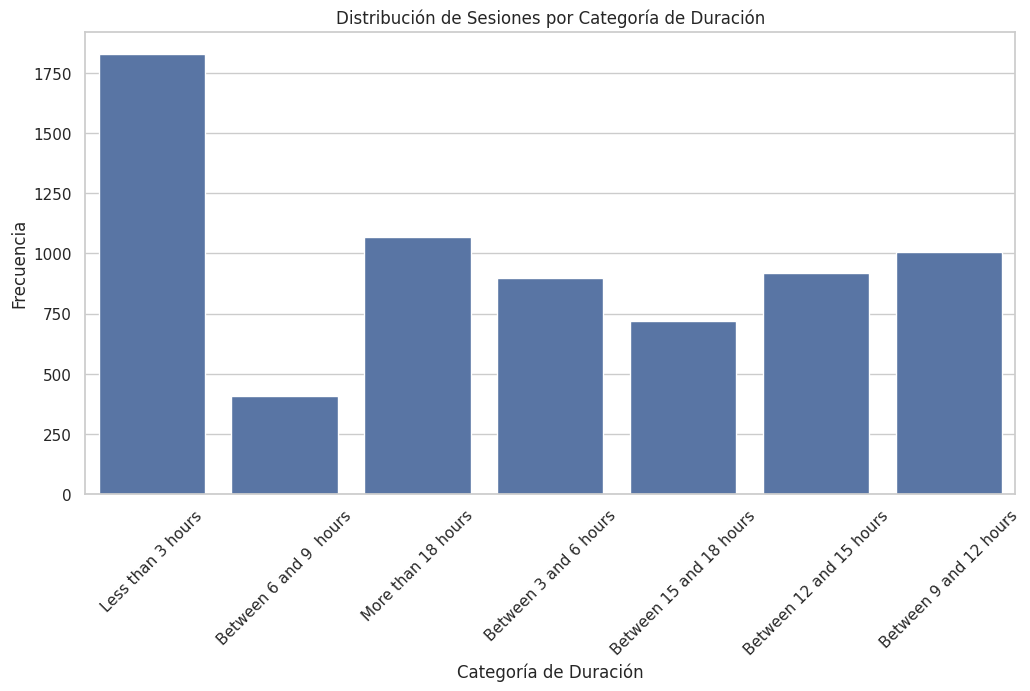

In [18]:
# Duration_category
plt.figure(figsize=(12, 6))
sns.countplot(x='Duration_category', data=df_charging)
plt.title('Distribución de Sesiones por Categoría de Duración')
plt.xlabel('Categoría de Duración')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

###Análisis Bivariante

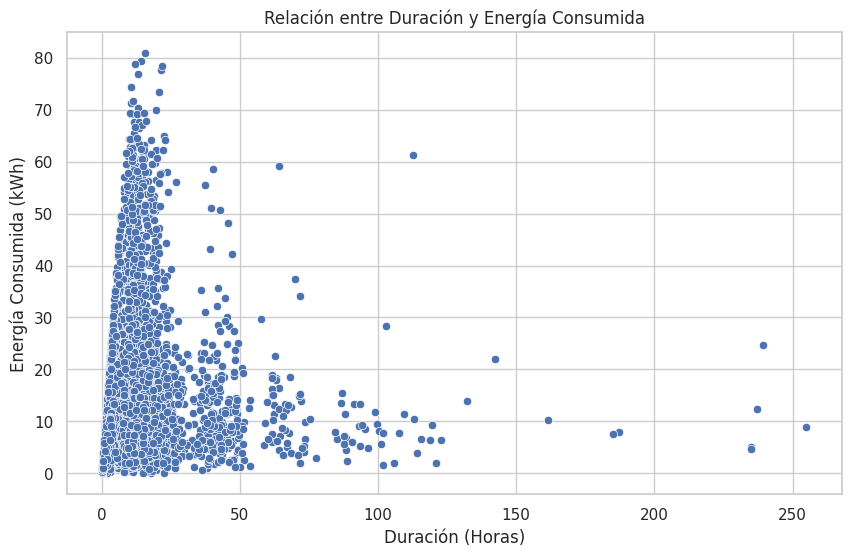

Correlación entre El_kWh y Duration_hours: 0.11


In [19]:
# Relación entre El_kWh y Duration_hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration_hours', y='El_kWh', data=df_charging)
plt.title('Relación entre Duración y Energía Consumida')
plt.xlabel('Duración (Horas)')
plt.ylabel('Energía Consumida (kWh)')
plt.show()

# Correlación
correlation = df_charging['El_kWh'].corr(df_charging['Duration_hours'])
print(f"Correlación entre El_kWh y Duration_hours: {correlation:.2f}")

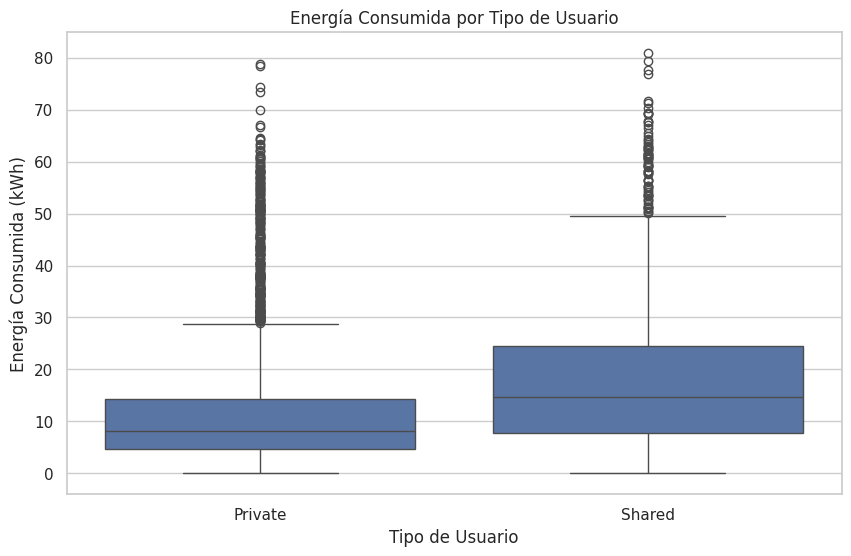

In [20]:
# Energía Consumida por Tipo de Usuario
plt.figure(figsize=(10, 6))
sns.boxplot(x='User_type', y='El_kWh', data=df_charging)
plt.title('Energía Consumida por Tipo de Usuario')
plt.xlabel('Tipo de Usuario')
plt.ylabel('Energía Consumida (kWh)')
plt.show()

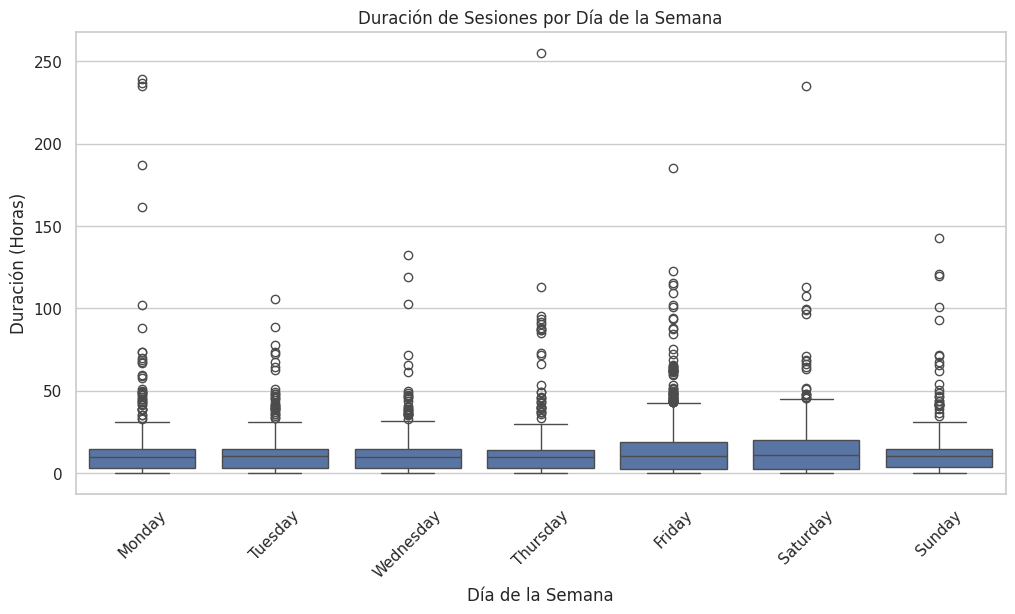

In [21]:
# Duración por Día de la Semana
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekdays_plugin', y='Duration_hours', data=df_charging, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Duración de Sesiones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Duración (Horas)')
plt.xticks(rotation=45)
plt.show()

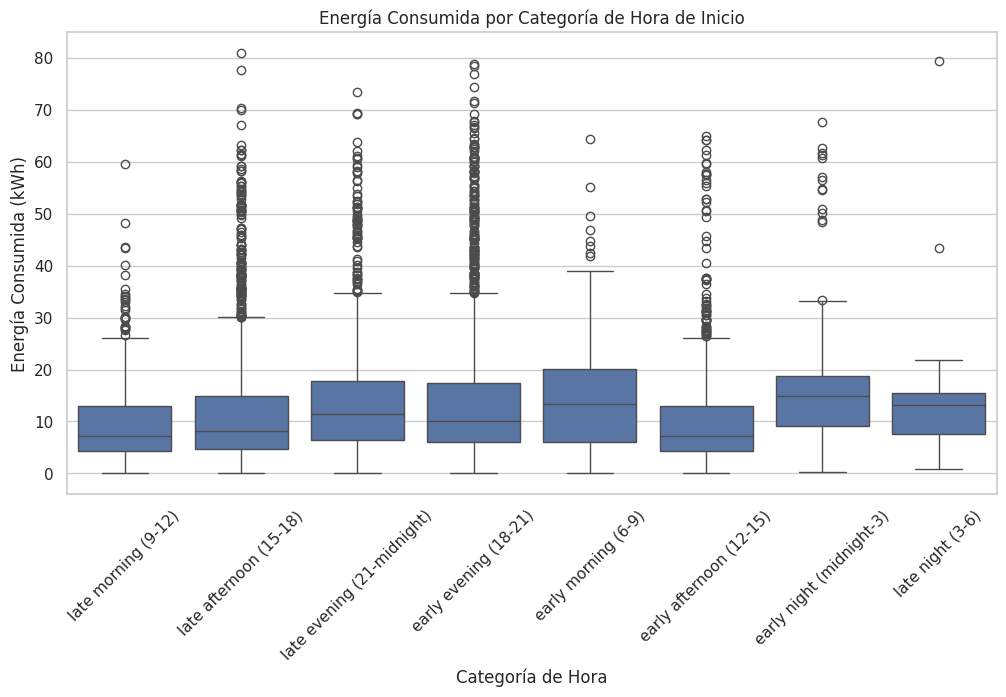

In [22]:
# Energía Consumida por Categoría de Hora
plt.figure(figsize=(12, 6))
sns.boxplot(x='Plugin_category', y='El_kWh', data=df_charging)
plt.title('Energía Consumida por Categoría de Hora de Inicio')
plt.xlabel('Categoría de Hora')
plt.ylabel('Energía Consumida (kWh)')
plt.xticks(rotation=45)
plt.show()

###Análisis Temporal

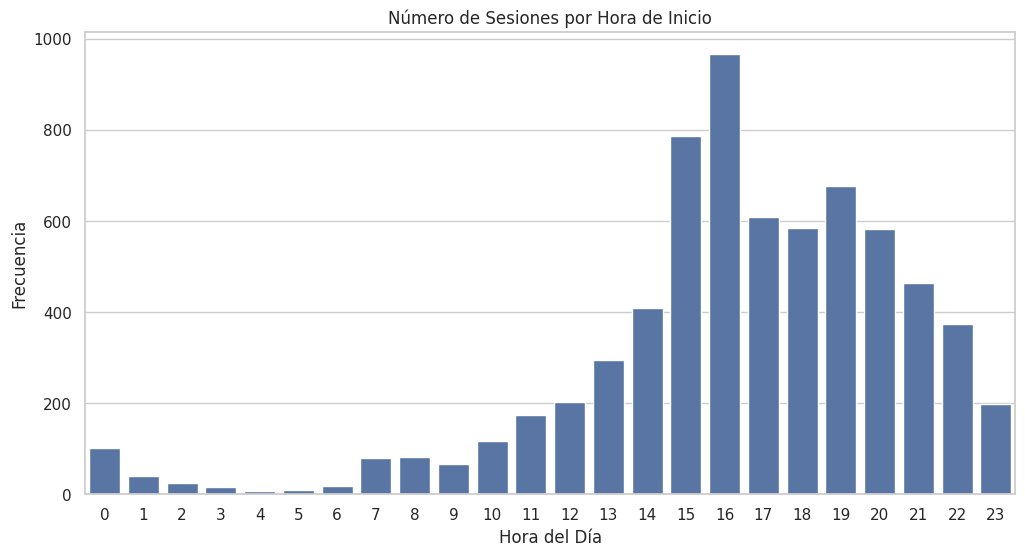

In [23]:
# Sesiones por Hora del Día
plt.figure(figsize=(12, 6))
sns.countplot(x='Start_plugin_hour', data=df_charging)
plt.title('Número de Sesiones por Hora de Inicio')
plt.xlabel('Hora del Día')
plt.ylabel('Frecuencia')
plt.show()

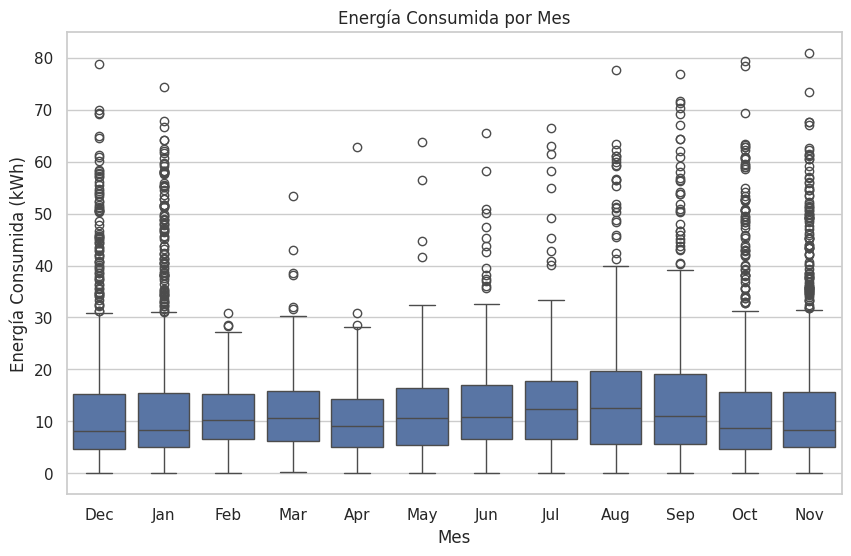

In [24]:
# Energía Consumida por Mes
plt.figure(figsize=(10, 6))
sns.boxplot(x='month_plugin', y='El_kWh', data=df_charging)
plt.title('Energía Consumida por Mes')
plt.xlabel('Mes')
plt.ylabel('Energía Consumida (kWh)')
plt.show()

In [25]:
df_charging['datetime'] = df_charging['Start_plugin'].dt.date
df_charging['datetime'] = pd.to_datetime(df_charging['datetime'])
df_charging["datetime_plugin_hour"] = df_charging["Start_plugin"].dt.floor("h")

In [26]:
# Definir los días que son fin de semana
weekend_days = {'saturday', 'sunday'}

# Crear una nueva columna con la clasificación
df_charging['is_weekend'] = df_charging['weekdays_plugin'].str.lower().apply(
    lambda x: 'weekend' if x in weekend_days else 'weekday'
)

In [27]:
df_charging['charge_complete'] = df_charging['Duration_hours'].notna()

In [28]:
df_charging.head(5)

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,datetime,datetime_plugin_hour,is_weekend,charge_complete
0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21,2018-12-21 10:00:00,weekday,True
1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21,2018-12-21 10:00:00,weekday,True
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,2018-12-21,2018-12-21 11:00:00,weekday,True
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,2018-12-22,2018-12-22 16:00:00,weekend,True
4,5,AdO3,AdO3-2,Private,NaN,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,2018-12-24,2018-12-24 22:00:00,weekday,True


In [29]:
df_weather.head(5)

,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,66,2018-12-01,-1.7,5,40,6,34,288,48,9.1,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,64,2018-12-02,-2.8,5,38,6,33,281,46,7.3,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,100,2018-12-03,-0.7,5,37,5,33,273,44,7.2,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,93,2018-12-04,-0.5,5,35,5,32,266,42,2.8,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,87,2018-12-05,-1.9,5,34,5,32,260,41,0.7,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


In [30]:
df_traffic.head(5)

,Date_from,Date_to,KROPPAN BRU,MOHOLTLIA,SELSBAKK,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen
0,01.12.2018 00:00,01.12.2018 01:00,639,0,0,4,144
1,01.12.2018 01:00,01.12.2018 02:00,487,153,115,21,83
2,01.12.2018 02:00,01.12.2018 03:00,408,85,75,10,69
3,01.12.2018 03:00,01.12.2018 04:00,282,89,56,8,39
4,01.12.2018 04:00,01.12.2018 05:00,165,64,34,3,25


In [31]:
# Convertir Start/End_plugin a tipo datetime
df_traffic['Date_from'] = pd.to_datetime(df_traffic['Date_from'], format="%d.%m.%Y %H:%M", errors='coerce')
df_traffic['Date_to'] = pd.to_datetime(df_traffic['Date_to'], format="%d.%m.%Y %H:%M", errors='coerce')

In [32]:
df_traffic['KROPPAN BRU'] = df_traffic['KROPPAN BRU'].replace('-', 0)
df_traffic['MOHOLTLIA'] = df_traffic['MOHOLTLIA'].replace('-', 0)
df_traffic['SELSBAKK'] = df_traffic['SELSBAKK'].replace('-', 0)

df_traffic['KROPPAN BRU'] = df_traffic['KROPPAN BRU'].notna().astype(int)
df_traffic['MOHOLTLIA'] = df_traffic['MOHOLTLIA'].notna().astype(int)
df_traffic['SELSBAKK'] = df_traffic['SELSBAKK'].notna().astype(int)

In [33]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

In [34]:
# Unir datasets (df_charging, df_traffic, df_weather)
# Unir con df_weather DATASET
df_merged = pd.merge(
    df_charging,
    df_weather,
    on="datetime",
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_traffic,
    left_on="datetime_plugin_hour",
    right_on="Date_from",
    how="left"
)

In [35]:
df_merged.head(5)

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,...,wind_dir,wind_gust_spd,wind_spd,Date_from,Date_to,KROPPAN BRU,MOHOLTLIA,SELSBAKK,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen
0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10.0,0.30,...,176,12.0,2.4,2018-12-21 10:00:00,2018-12-21 11:00:00,1,1,1,194,622
1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10.0,0.87,...,176,12.0,2.4,2018-12-21 10:00:00,2018-12-21 11:00:00,1,1,1,194,622
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,...,176,12.0,2.4,2018-12-21 11:00:00,2018-12-21 12:00:00,1,1,1,230,771
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,...,137,9.2,1.9,2018-12-22 16:00:00,2018-12-22 17:00:00,1,1,1,224,694
4,5,AdO3,AdO3-2,Private,NaN,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23.0,3.62,...,203,12.4,3.8,2018-12-24 22:00:00,2018-12-24 23:00:00,1,1,1,83,353


In [36]:
df_merged.columns

Index(['session_ID', 'Garage_ID', 'User_ID', 'User_type', 'Shared_ID',
       'Start_plugin', 'Start_plugin_hour', 'End_plugout', 'End_plugout_hour',
       'El_kWh', 'Duration_hours', 'month_plugin', 'weekdays_plugin',
       'Plugin_category', 'Duration_category', 'datetime',
       'datetime_plugin_hour', 'is_weekend', 'charge_complete', 'clouds',
       'dewpt', 'dhi', 'dni', 'ghi', 'max_dhi', 'max_dni', 'max_ghi',
       'max_temp', 'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',
       'max_wind_spd_ts', 'min_temp', 'min_temp_ts', 'precip', 'precip_gpm',
       'pres', 'revision_status', 'rh', 'slp', 'snow', 'snow_depth',
       'solar_rad', 't_dhi', 't_dni', 't_ghi', 't_solar_rad', 'temp', 'ts',
       'wind_dir', 'wind_gust_spd', 'wind_spd', 'Date_from', 'Date_to',
       'KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK', 'MOHOLT RAMPE 2',
       'Jonsvannsveien vest for Steinanvegen'],
      dtype='object')

In [37]:
# Codificacion de variables categoricas
# One-Hot Encoding: nominales; crea una columna por valor de variable
# Label Encoding: Categorias con orden; para no crear nuevas columnas
# Manual
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# categoric_columns = ["User_type", "weekdays_plugin", "Plugin_category", "month_plugin", "revision_status", "day_type" , "charge_complete"]

# for col in categoric_columns:
#     df_merged[col] = le.fit_transform(df_merged[col])

In [38]:
# El modelo esta bien, solo HAY QUE ESPECIFICAR EL ORDEN DE LSA VARIABLES

# Mapear user type
df_merged['user_type_binary'] = df_merged['User_type'].map({'Private': 0, 'Shared': 1})

# Mapear días de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_merged['weekday_num'] = df_merged['weekdays_plugin'].map({day: i for i, day in enumerate(dias_orden)})
# Codificación cíclica
df_merged['sin_weekday'] = np.sin(2 * np.pi * df_merged['weekday_num'] / 7)
df_merged['cos_weekday'] = np.cos(2 * np.pi * df_merged['weekday_num'] / 7)

# Mapear categoria hora de conexion
plugin_mapping = {
    'early night (midnight-3)': 0,
    'late night (3-6)': 1,
    'early morning (6-9)': 2,
    'late morning (9-12)': 3,
    'early afternoon (12-15)': 4,
    'late afternoon (15-18)': 5,
    'early evening (18-21)': 6,
    'late evening (21-midnight)': 7,
}
df_merged['plugin_bin'] = df_merged['Plugin_category'].map(plugin_mapping)
df_merged['plugin_sin'] = np.sin(2 * np.pi * df_merged['plugin_bin'] / 8)
df_merged['plugin_cos'] = np.cos(2 * np.pi * df_merged['plugin_bin'] / 8)

# Mapear meses
meses_orden = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_merged['month_num'] = df_merged['month_plugin'].map({month: i+1 for i, month in enumerate(meses_orden)})


df_merged['sin_month'] = np.sin(2 * np.pi * df_merged['month_num'] / 12)
df_merged['cos_month'] = np.cos(2 * np.pi * df_merged['month_num'] / 12)

# Convertir booleanos a numéricos
df_merged['is_weekend'] = df_merged['is_weekend'].map({'weekday': 0, 'weekend': 1})
df_merged['charge_complete'] = df_merged['charge_complete'].astype(int)  # True/False → 1/0

In [39]:
# Seleccionar solo columnas numéricas (int y float)
df_encoded = df_merged.select_dtypes(include=['int64', 'float64'])

In [40]:
df_encoded.columns

Index(['session_ID', 'Start_plugin_hour', 'End_plugout_hour', 'El_kWh',
       'Duration_hours', 'is_weekend', 'charge_complete', 'clouds', 'dewpt',
       'dhi', 'dni', 'ghi', 'max_dhi', 'max_dni', 'max_ghi', 'max_temp',
       'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',
       'max_wind_spd_ts', 'min_temp', 'min_temp_ts', 'precip', 'precip_gpm',
       'pres', 'rh', 'slp', 'snow', 'snow_depth', 'solar_rad', 't_dhi',
       't_dni', 't_ghi', 't_solar_rad', 'temp', 'ts', 'wind_dir',
       'wind_gust_spd', 'wind_spd', 'KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK',
       'MOHOLT RAMPE 2', 'Jonsvannsveien vest for Steinanvegen',
       'user_type_binary', 'weekday_num', 'sin_weekday', 'cos_weekday',
       'plugin_bin', 'plugin_sin', 'plugin_cos', 'month_num', 'sin_month',
       'cos_month'],
      dtype='object')

In [41]:
columns = ['Start_plugin_hour', 'End_plugout_hour', 'El_kWh',
       'Duration_hours', 'is_weekend', 'charge_complete', 'clouds', 'dewpt',
       'dhi', 'dni', 'ghi', 'max_dhi', 'max_dni', 'max_ghi', 'max_temp',
       'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',
       'max_wind_spd_ts', 'min_temp', 'min_temp_ts', 'precip', 'precip_gpm',
       'pres', 'rh', 'slp', 'snow', 'snow_depth', 'solar_rad', 't_dhi',
       't_dni', 't_ghi', 't_solar_rad', 'temp', 'ts', 'wind_dir',
       'wind_gust_spd', 'wind_spd', 'KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK',
       'MOHOLT RAMPE 2', 'Jonsvannsveien vest for Steinanvegen',
       'user_type_binary', 'plugin_sin', 'plugin_cos', 'month_num',
       'sin_weekday', 'cos_weekday', 'sin_month', 'cos_month']

In [42]:
df_encoded = df_encoded[columns]

array([[<Axes: title={'center': 'Start_plugin_hour'}>,
        <Axes: title={'center': 'End_plugout_hour'}>,
        <Axes: title={'center': 'El_kWh'}>,
        <Axes: title={'center': 'Duration_hours'}>,
        <Axes: title={'center': 'is_weekend'}>,
        <Axes: title={'center': 'charge_complete'}>,
        <Axes: title={'center': 'clouds'}>],
       [<Axes: title={'center': 'dewpt'}>,
        <Axes: title={'center': 'dhi'}>, <Axes: title={'center': 'dni'}>,
        <Axes: title={'center': 'ghi'}>,
        <Axes: title={'center': 'max_dhi'}>,
        <Axes: title={'center': 'max_dni'}>,
        <Axes: title={'center': 'max_ghi'}>],
       [<Axes: title={'center': 'max_temp'}>,
        <Axes: title={'center': 'max_temp_ts'}>,
        <Axes: title={'center': 'max_uv'}>,
        <Axes: title={'center': 'max_wind_dir'}>,
        <Axes: title={'center': 'max_wind_spd'}>,
        <Axes: title={'center': 'max_wind_spd_ts'}>,
        <Axes: title={'center': 'min_temp'}>],
       [<Axes: t

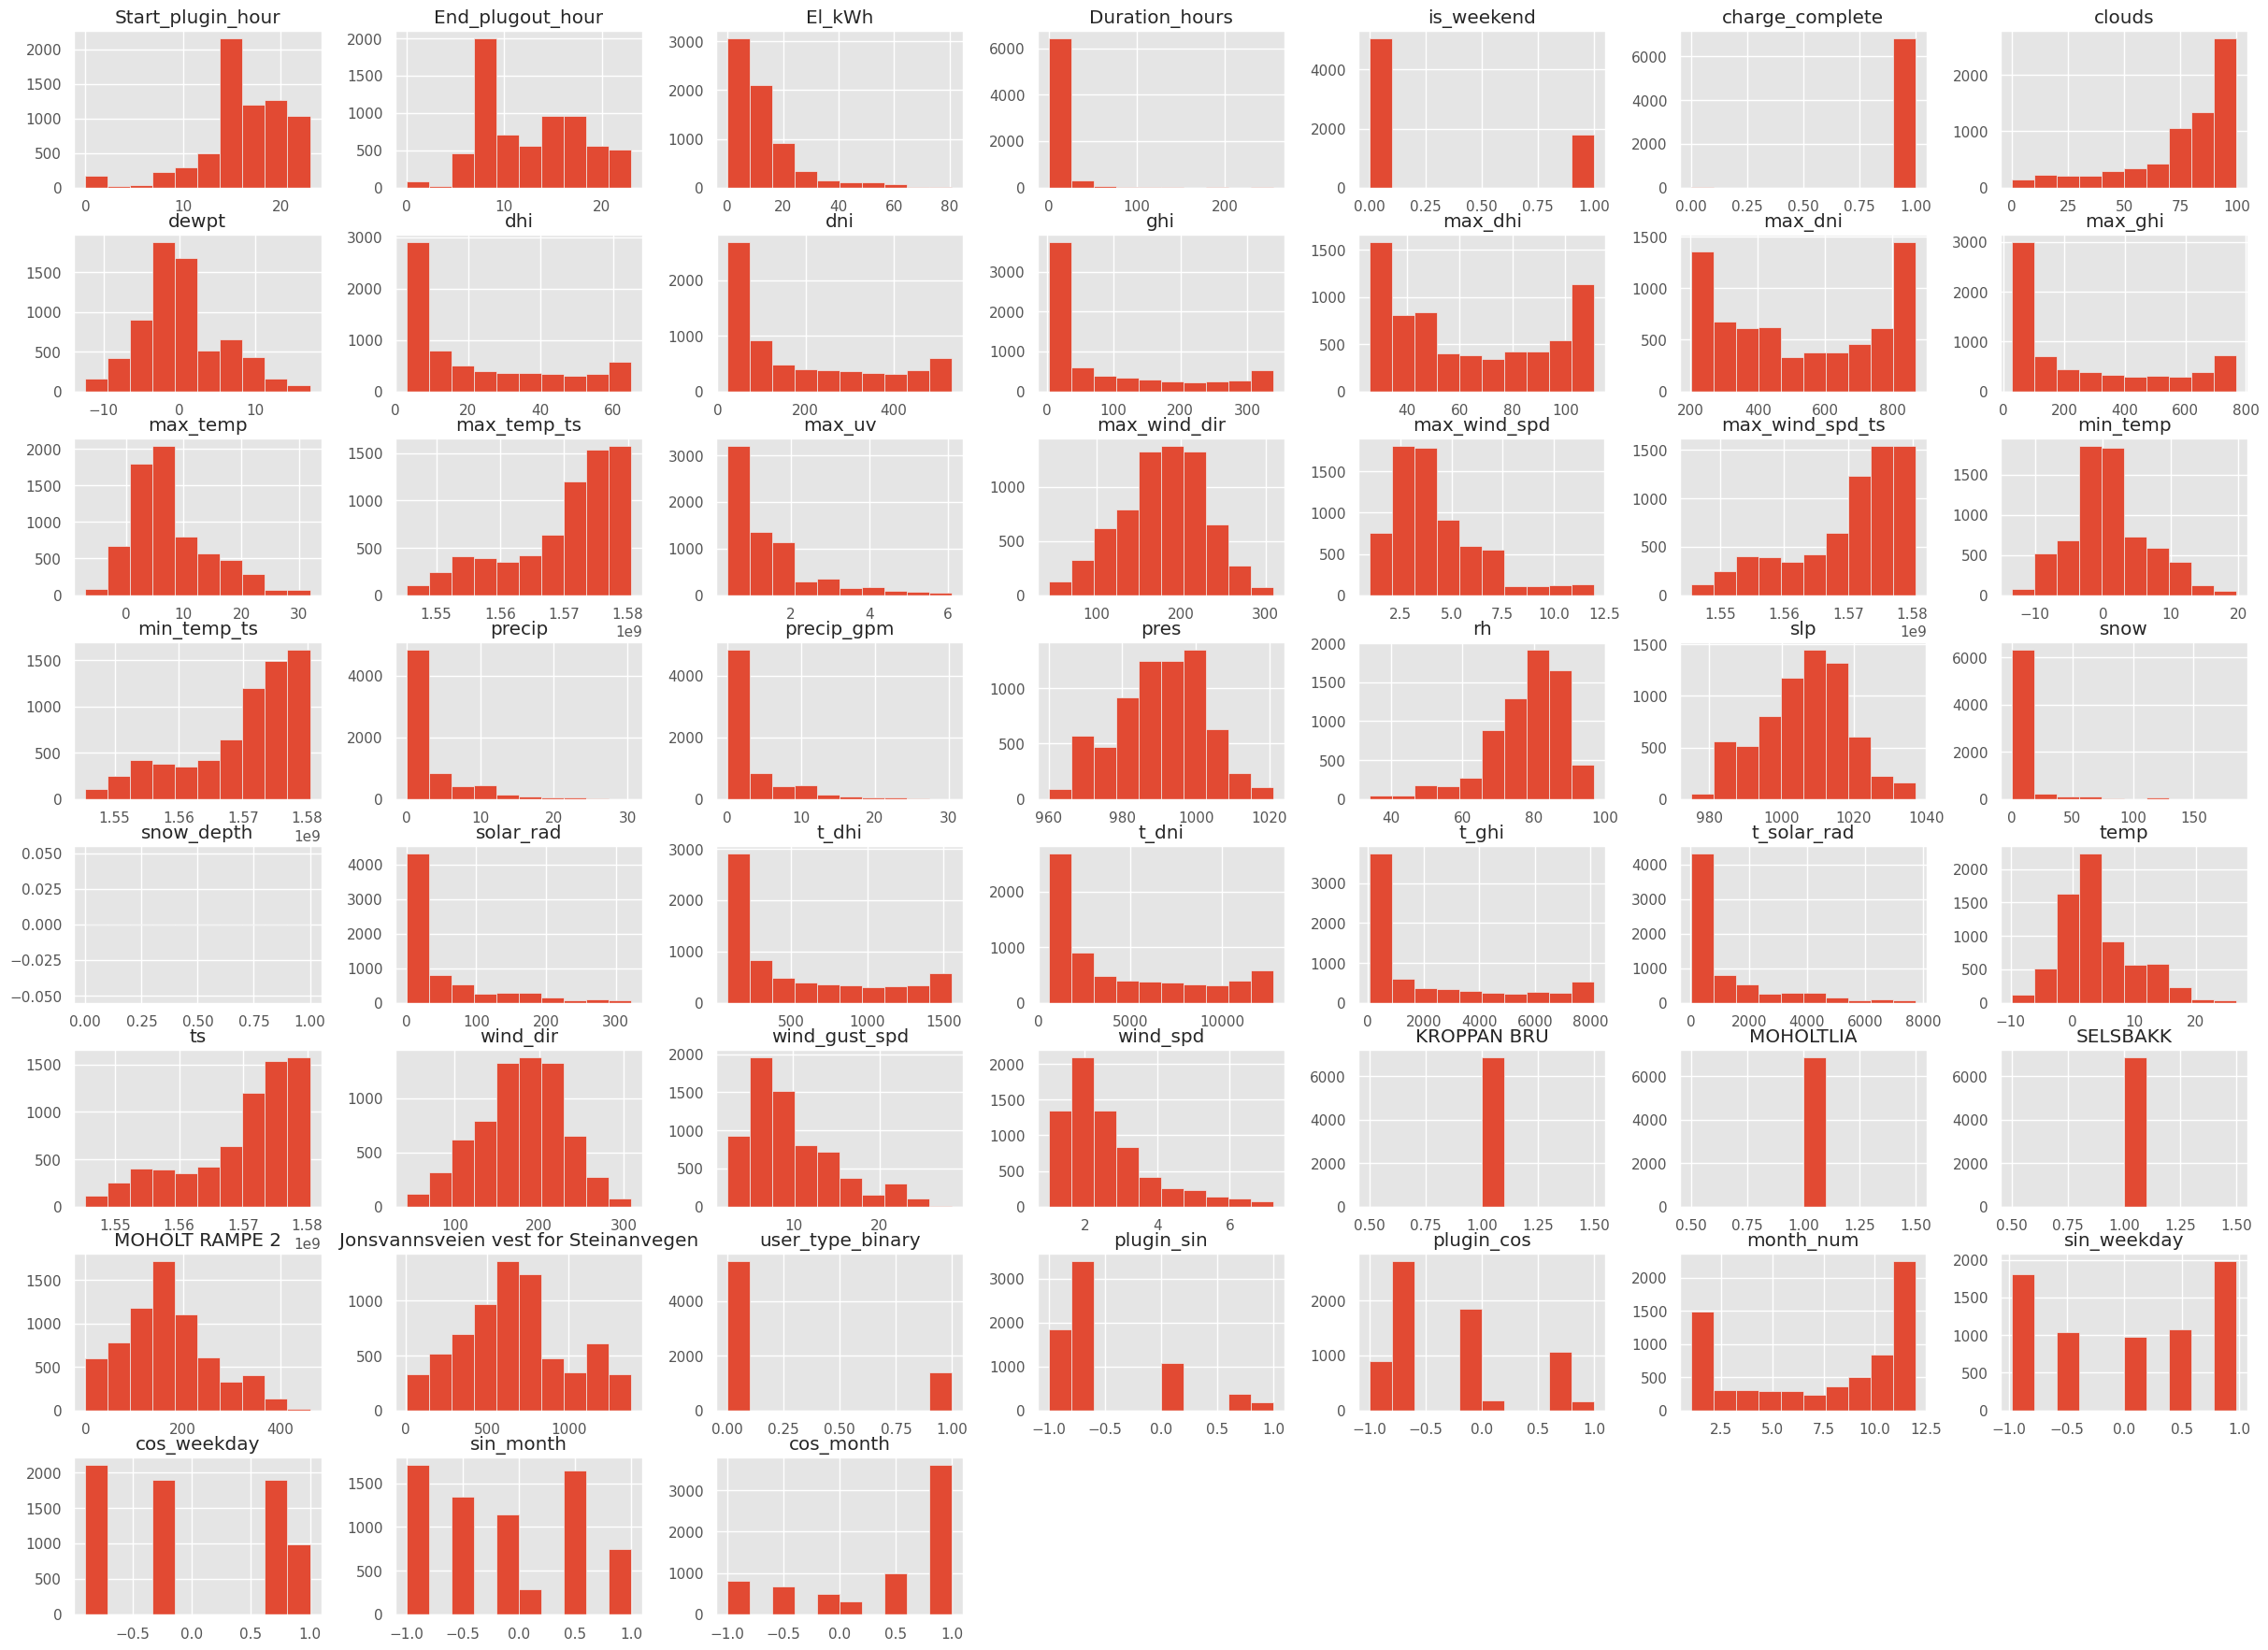

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#Configuramos parámetros para ver las figuras en tamaño adecuado
plt.rcParams['figure.figsize'] = (30, 22)
plt.style.use('ggplot')
df_merged[columns].hist()

In [44]:
# complete_charge no aporta al modelo, por tanto se elimina
# df_merged = df_merged.drop(['charge_complete'], axis=1)

In [45]:
df_encoded['Duration_hours'].describe()

,Duration_hours
count,6844.000000
mean,11.504440
std,14.148168
min,0.003333
25%,2.789028
50%,10.026250
75%,15.221181
max,255.029444


<Axes: >

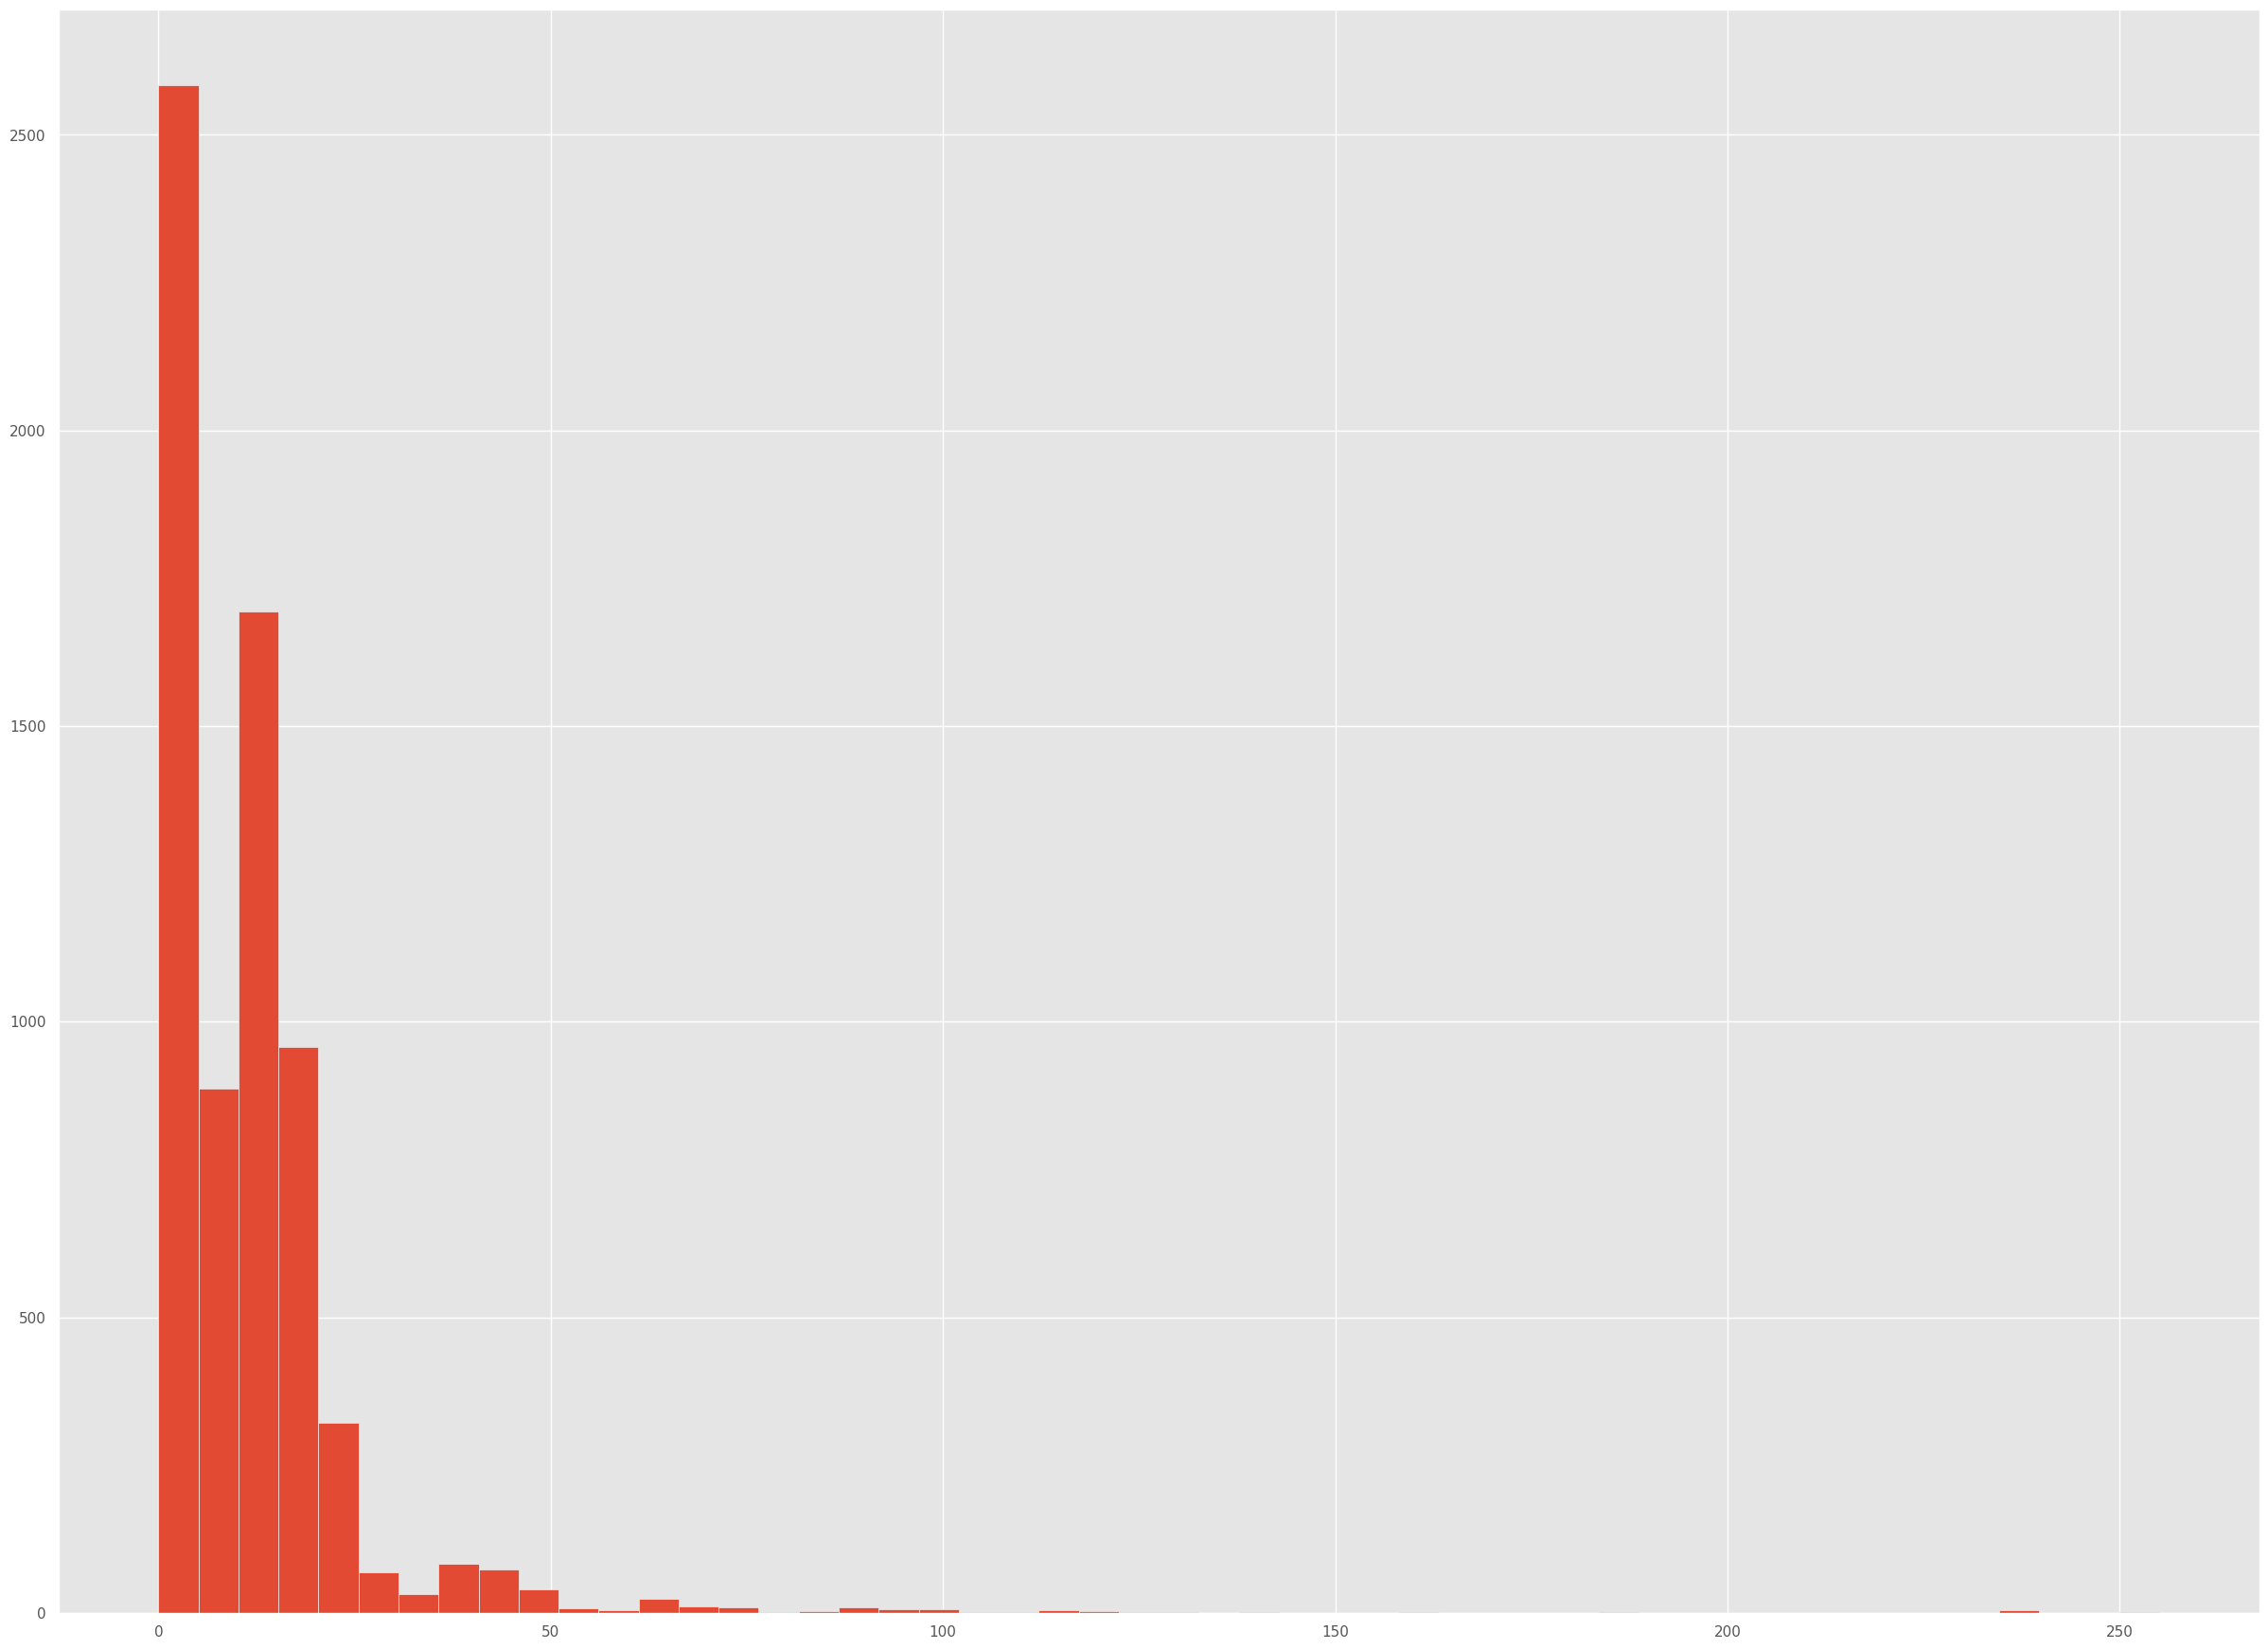

In [46]:
df_encoded['Duration_hours'].hist(bins=50)

In [47]:
# print(df_encoded[df_encoded['Duration_hours'] > 50])

# df_filtered = df_encoded
df_filtered = df_encoded[df_encoded['Duration_hours'] <= 100]

df_filtered['log_duration'] = np.log1p(df_filtered['Duration_hours'])
# df_filtered['Duration_hours'] = np.sqrt(df_filtered['Duration_hours'])
df_filtered.drop(['Duration_hours'], axis=1, inplace=True)
# df_filtered.drop(['Duration_category'], axis=1, inplace=True)

# df_encoded.drop(['Duration_category'], axis=1, inplace=True)

<ipython-input-47-25908f979ae9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_duration'] = np.log1p(df_filtered['Duration_hours'])
<ipython-input-47-25908f979ae9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(['Duration_hours'], axis=1, inplace=True)


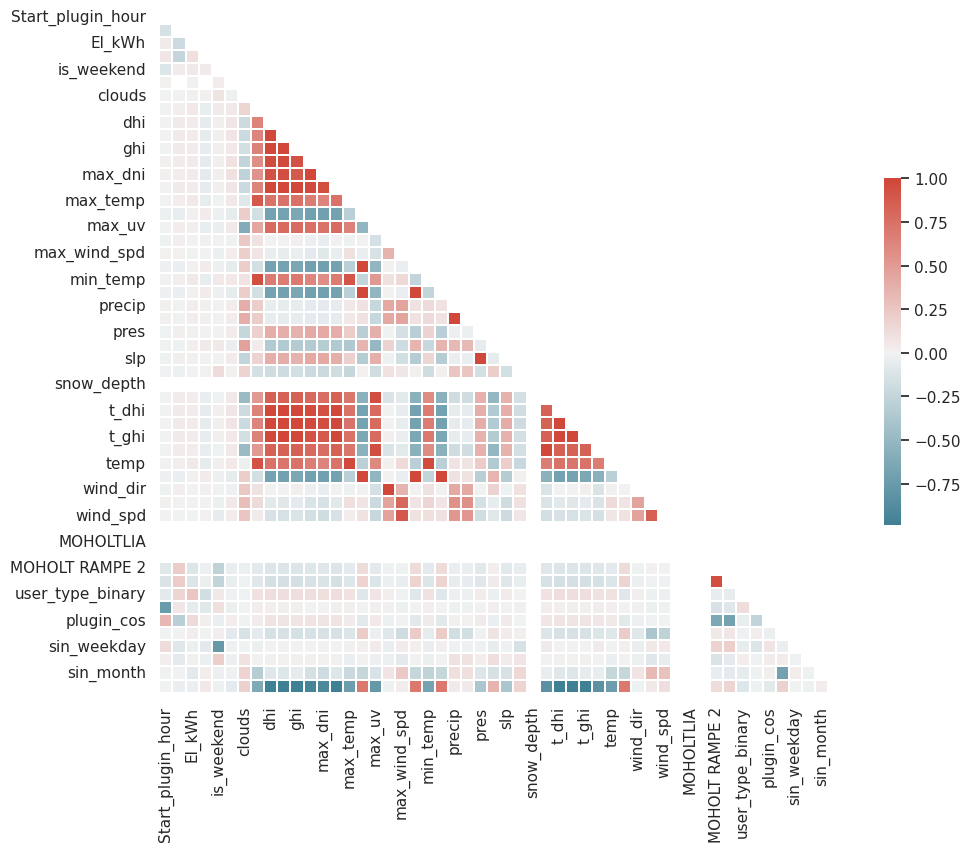

In [48]:
sns.set(style="white")
# Compute the correlation matrix
corr = df_encoded.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 15, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})
plt.show()

In [49]:
df_encoded.corr()['Duration_hours'].sort_values(ascending=False)

,Duration_hours
Duration_hours,1.000000
El_kWh,0.105448
Start_plugin_hour,0.063061
cos_month,0.053928
is_weekend,0.040180
rh,0.038975
ts,0.033041
max_wind_spd_ts,0.033005
min_temp_ts,0.033002
max_temp_ts,0.032970


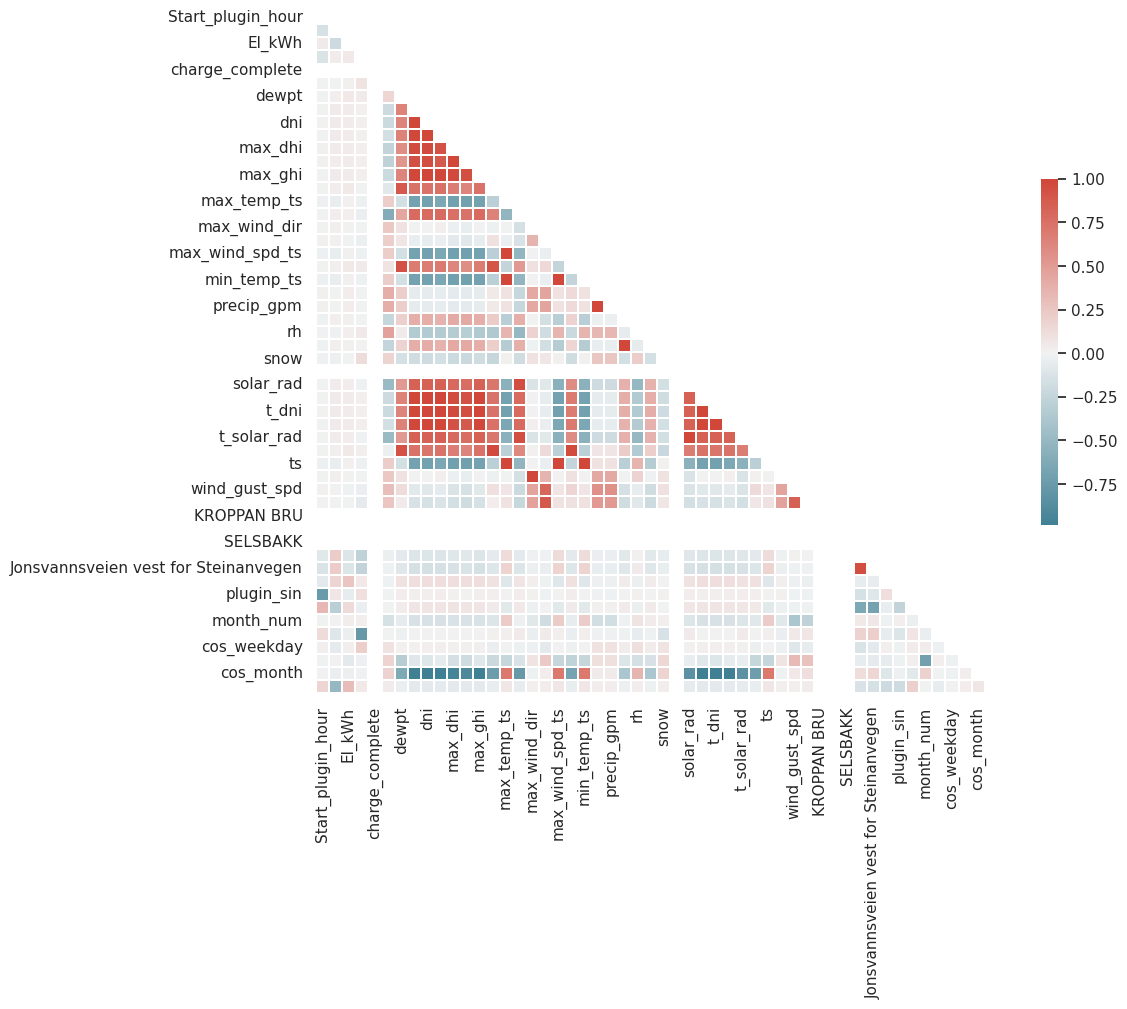

In [50]:
sns.set(style="white")
# Compute the correlation matrix
corr = df_filtered.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 15, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})
plt.show()

In [51]:
df_filtered.corr()['log_duration'].sort_values(ascending=False)

,log_duration
log_duration,1.000000
El_kWh,0.305055
plugin_cos,0.193997
Start_plugin_hour,0.163383
ts,0.067402
max_temp_ts,0.067367
min_temp_ts,0.067356
max_wind_spd_ts,0.067301
cos_month,0.067033
is_weekend,0.054511


In [52]:
df_encoded = df_encoded.dropna(subset=['Duration_hours'])
df_filtered = df_filtered.dropna(subset=['log_duration'])

In [53]:
df_encoded.shape

(6844, 52)

                                Variable  Importancia
1                       End_plugout_hour     0.213916
2                                 El_kWh     0.129398
0                      Start_plugin_hour     0.098129
13                              max_temp     0.050383
42  Jonsvannsveien vest for Steinanvegen     0.049886
41                        MOHOLT RAMPE 2     0.045856
47                           sin_weekday     0.027859
33                                  temp     0.027717
24                                    rh     0.020047
45                            plugin_cos     0.019206
16                          max_wind_dir     0.019001
35                              wind_dir     0.018390
6                                  dewpt     0.016131
37                              wind_spd     0.014795
36                         wind_gust_spd     0.014712
19                              min_temp     0.014635
44                            plugin_sin     0.014438
25                          

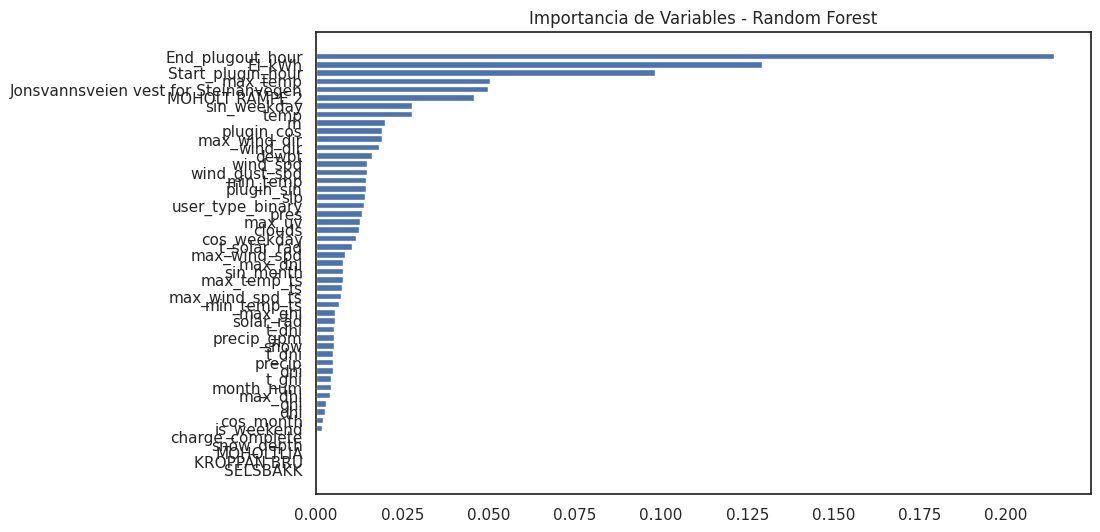

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Separar variables predictoras y target
X = df_encoded.drop('Duration_hours', axis=1)
y = df_encoded['Duration_hours']

# Entrenar el modelo
model = RandomForestRegressor()
model.fit(X, y)

# Importancia de variables
importancias = model.feature_importances_

# Visualizar
importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print(importancia_df)

plt.figure(figsize=(10,6))
plt.barh(importancia_df['Variable'], importancia_df['Importancia'])
plt.gca().invert_yaxis()
plt.title('Importancia de Variables - Random Forest')
plt.show()


                                Variable  Importancia
1                       End_plugout_hour     0.394367
2                                 El_kWh     0.184150
0                      Start_plugin_hour     0.094558
44                            plugin_sin     0.083191
45                            plugin_cos     0.046561
42  Jonsvannsveien vest for Steinanvegen     0.023443
41                        MOHOLT RAMPE 2     0.021036
43                      user_type_binary     0.012917
24                                    rh     0.009729
47                           sin_weekday     0.009018
37                              wind_spd     0.008172
35                              wind_dir     0.007293
36                         wind_gust_spd     0.007120
16                          max_wind_dir     0.006638
32                           t_solar_rad     0.006588
5                                 clouds     0.006581
25                                   slp     0.006122
23                          

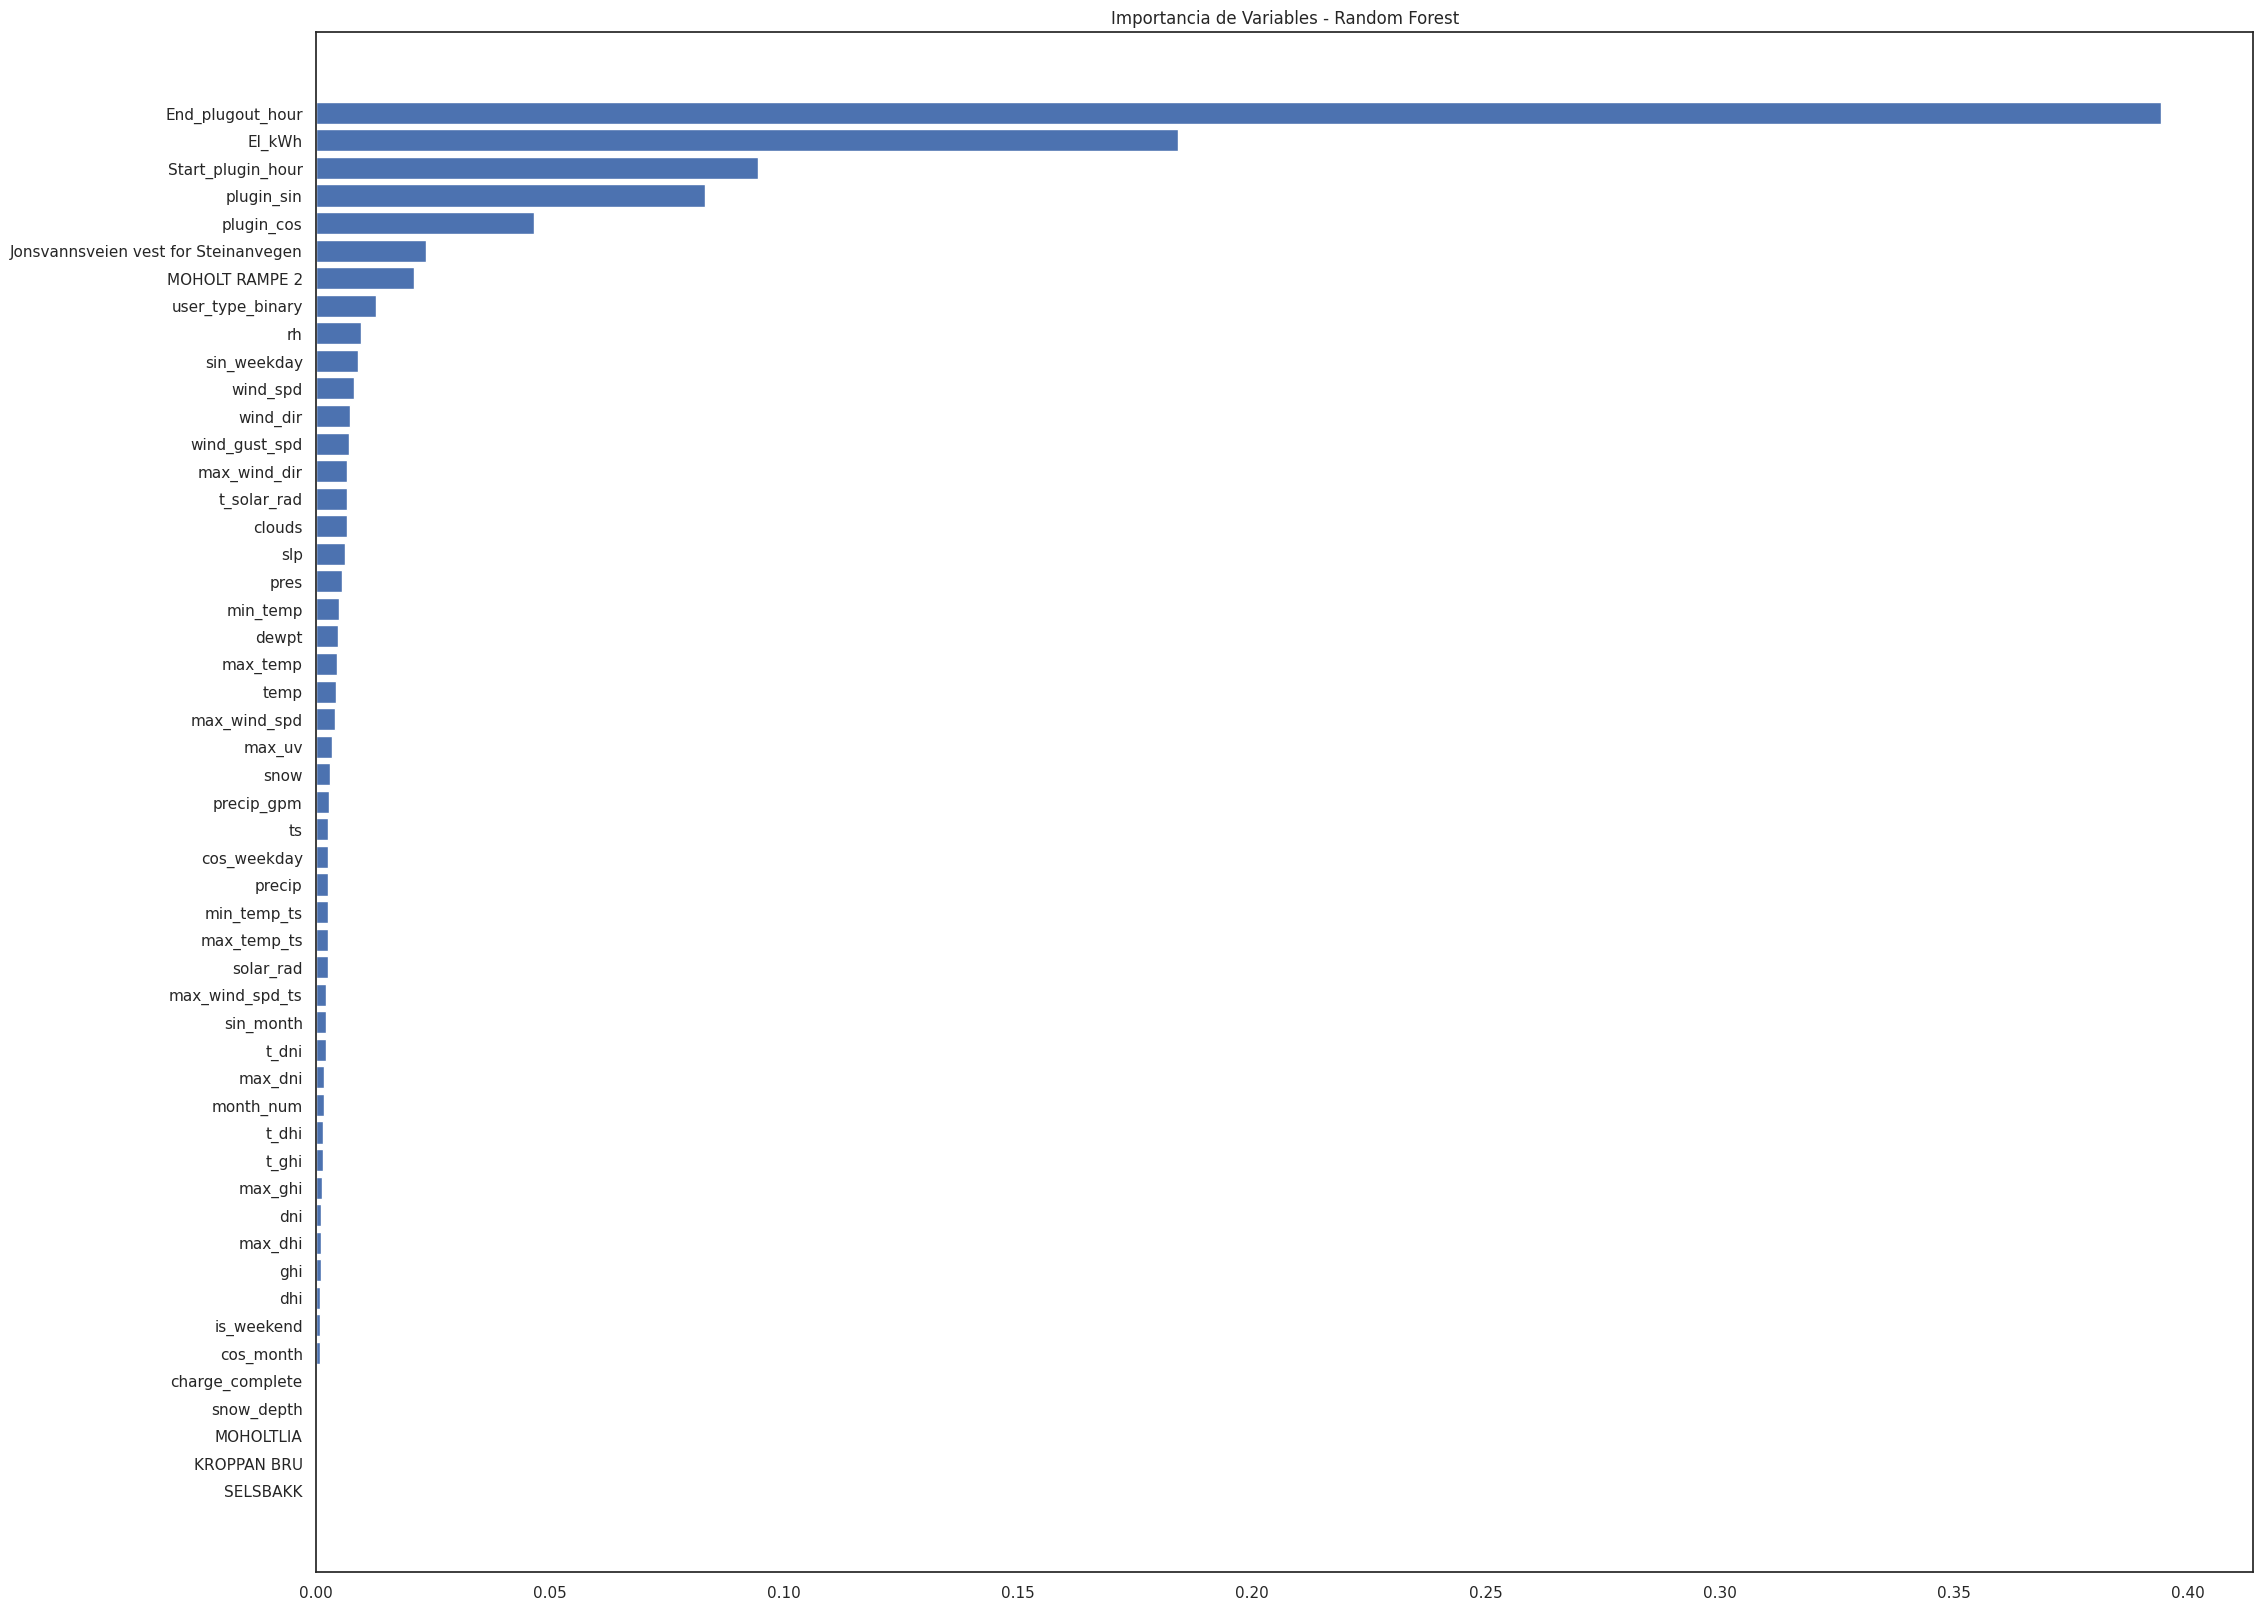

In [55]:
from sklearn.ensemble import RandomForestRegressor

# Separar variables predictoras y target
X = df_filtered.drop('log_duration', axis=1)
y = df_filtered['log_duration']

# Entrenar el modelo
model = RandomForestRegressor()
model.fit(X, y)

# Importancia de variables
importancias = model.feature_importances_

# Visualizar
import pandas as pd
import matplotlib.pyplot as plt

importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print(importancia_df)

plt.figure(figsize=(25,20))
plt.barh(importancia_df['Variable'], importancia_df['Importancia'])
plt.gca().invert_yaxis()
plt.title('Importancia de Variables - Random Forest')
plt.show()


In [56]:
# sns.scatterplot(x=df_merged['El_kWh'], y=df_merged['Duration_hours'])
# sns.regplot(x="El_kWh", y="Duration_hours", data=df_merged)

In [57]:
# sns.regplot(x="max_temp", y="Duration_hours", data=df_merged)

In [58]:
# sns.regplot(x="Start_plugin_hour", y="Duration_hours", data=df_merged)

In [59]:
# sns.regplot(x="End_plugout_hour", y="Duration_hours", data=df_merged)

In [60]:
# sns.boxplot(x=df_merged['User_type'], y=df_merged['Duration_hours'])

In [61]:
df_filtered['log_El_kWh'] = np.log1p(df_filtered['El_kWh'])

In [62]:
# Importar librerias necesarias
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
# 1                       End_plugout_hour     0.390212
# 2                                 El_kWh     0.186827
# 0                      Start_plugin_hour     0.089302
# 44                            plugin_sin     0.086266
# 45                            plugin_cos     0.046848
# 42  Jonsvannsveien vest for Steinanvegen     0.023854
# 41                        MOHOLT RAMPE 2     0.020949
# 43                      user_type_binary     0.014357
# 47                           sin_weekday     0.009878
# 24                                    rh     0.009653
# 37                              wind_spd     0.008323

In [64]:
# # Variables predictoras
# features = ["End_plugout_hour", "Start_plugin_hour", "log_El_kWh",
#             "MOHOLT RAMPE 2", "Jonsvannsveien vest for Steinanvegen",
#             "user_type_binary", "wind_gust_spd", "rh",
#             "plugin_sin", "plugin_cos", "sin_weekday", "cos_weekday", "t_solar_rad"]     #, 'month_plugin', 'weekdays_plugin', "is_weekend", "sin_weekday", "max_temp"

In [65]:
# Variables predictoras
features = ["End_plugout_hour",  "log_El_kWh", "Start_plugin_hour",
            "plugin_sin", "plugin_cos", "Jonsvannsveien vest for Steinanvegen",
            "MOHOLT RAMPE 2", "user_type_binary", "sin_weekday", "rh",
            "wind_spd"]     #, 'month_plugin', 'weekdays_plugin', "is_weekend", "sin_weekday", "max_temp"

In [66]:
X = df_filtered[features].copy()
y = df_filtered['log_duration']

In [67]:
# # Escalar de variables numéricas
# numerical_features = ['End_plugout_hour', 'Start_plugin_hour', 'rh', 'wind_gust_spd',
#                       'MOHOLT RAMPE 2', 'Jonsvannsveien vest for Steinanvegen', 't_solar_rad']    #  'max_temp'
# scaler = StandardScaler()
# X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [68]:
# Escalar de variables numéricas
numerical_features = ["End_plugout_hour", "Start_plugin_hour", "Jonsvannsveien vest for Steinanvegen",
                      "MOHOLT RAMPE 2", "rh", "wind_spd"]    #  'max_temp'
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [69]:
# Dividir datos en entrenamiento, validación y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

In [70]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=125, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

In [71]:
print("\n--- Validación Cruzada (CV) ---\n")
for name, model in models.items():
    scores = cross_validate(model, X_train_full, y_train_full, cv=5, scoring=scoring)
    print(f"{name} - CV MAE: {-scores['test_mae'].mean():.4f} ± {scores['test_mae'].std():.4f}")
    print(f"{name} - CV RMSE: {-scores['test_rmse'].mean():.4f} ± {scores['test_rmse'].std():.4f}")
    print(f"{name} - CV R²: {scores['test_r2'].mean():.4f} ± {scores['test_r2'].std():.4f}\n")


--- Validación Cruzada (CV) ---

RandomForest - CV MAE: 0.2414 ± 0.0111
RandomForest - CV RMSE: 0.4692 ± 0.0220
RandomForest - CV R²: 0.7460 ± 0.0216

GradientBoosting - CV MAE: 0.3060 ± 0.0080
GradientBoosting - CV RMSE: 0.5002 ± 0.0158
GradientBoosting - CV R²: 0.7116 ± 0.0149

XGBoost - CV MAE: 0.2760 ± 0.0111
XGBoost - CV RMSE: 0.4910 ± 0.0194
XGBoost - CV R²: 0.7222 ± 0.0177

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 4363, number of used features: 11
[LightGBM] [Info] Start training from score 2.100437
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thr

In [72]:
# **Optimizar hiperparámetros con GridSearchCV para LightGBM**
param_grid_lgbm = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [10, 20, 31]
}

grid_search_lgbm = GridSearchCV(LGBMRegressor(), param_grid_lgbm, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Mejor modelo
best_model_lgbm = grid_search_lgbm.best_estimator_
print(f"Mejores parámetros de LightGBM: {grid_search_lgbm.best_params_}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 4363, number of used features: 11
[LightGBM] [Info] Start training from score 2.106308
Mejores parámetros de LightGBM: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 31}


In [73]:
# Entrenar el mejor modelo
best_model = models["LightGBM"]
best_model.fit(X_train, y_train)
y_pred_log = best_model.predict(X_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 4363, number of used features: 11
[LightGBM] [Info] Start training from score 2.106308


In [74]:
# Evaluación en validación (log)
print("\n--- Evaluación en Validación (log) ---")
print("MAE:", mean_absolute_error(y_val, y_pred_log))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_log)))
print("R²:", r2_score(y_val, y_pred_log))


--- Evaluación en Validación (log) ---
MAE: 0.25073622452775435
RMSE: 0.4581926818281461
R²: 0.7558601564287093


In [75]:
# Escala original
y_val_orig = np.expm1(y_val)
y_pred_orig = np.expm1(y_pred_log)
rmse_orig = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
print("RMSE (escala original):", rmse_orig)

RMSE (escala original): 8.407881838240844


In [76]:
# Red Neuronal
# Definir la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Salida para regresión
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae', 'mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4958 - mae: 1.0277 - mse: 1.7387 - val_loss: 1.0763 - val_mae: 0.5474 - val_mse: 0.4999
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1868 - mae: 0.6336 - mse: 0.6535 - val_loss: 0.8830 - val_mae: 0.5139 - val_mse: 0.4582
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9867 - mae: 0.5988 - mse: 0.5882 - val_loss: 0.7522 - val_mae: 0.4954 - val_mse: 0.4221
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8362 - mae: 0.5603 - mse: 0.5242 - val_loss: 0.6691 - val_mae: 0.4804 - val_mse: 0.4051
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7296 - mae: 0.5329 - mse: 0.4789 - val_loss: 0.5966 - val_mae: 0.4538 - val_mse: 0.3794
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6658 - mae: 0.5139 - mse: 0.4575 - val_loss: 0.5460 - val_mae: 0.4349 - val_mse: 0.3621
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5997 - mae: 0.4873 - mse: 0.422

In [77]:
# Evaluar el modelo en el conjunto de prueba
y_pred_nn_log = model.predict(X_test).flatten()
mae_log = mean_absolute_error(y_test, y_pred_nn_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_nn_log))
r2_log = r2_score(y_test, y_pred_nn_log)

print("\n--- Evaluación Red Neuronal en Test (log) ---")
print("MAE:", mae_log)
print("RMSE:", rmse_log)
print("R²:", r2_log)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Evaluación Red Neuronal en Test (log) ---
MAE: 0.19083380576906245
RMSE: 0.4003444566241764
R²: 0.8166786773388461


In [78]:
# Transformar las predicciones y valores reales de vuelta a la escala original
y_test_orig = np.expm1(y_test)
y_pred_nn_orig = np.expm1(y_pred_nn_log)

mae_orig = mean_absolute_error(y_test_orig, y_pred_nn_orig)
rmse_orig_nn = np.sqrt(mean_squared_error(y_test_orig, y_pred_nn_orig))

print("\n--- Evaluación Red Neuronal en Test (escala original) ---")
print("MAE:", mae_orig)
print("RMSE (escala original):", rmse_orig_nn)


--- Evaluación Red Neuronal en Test (escala original) ---
MAE: 2.5448105608435116
RMSE (escala original): 7.416621949200753


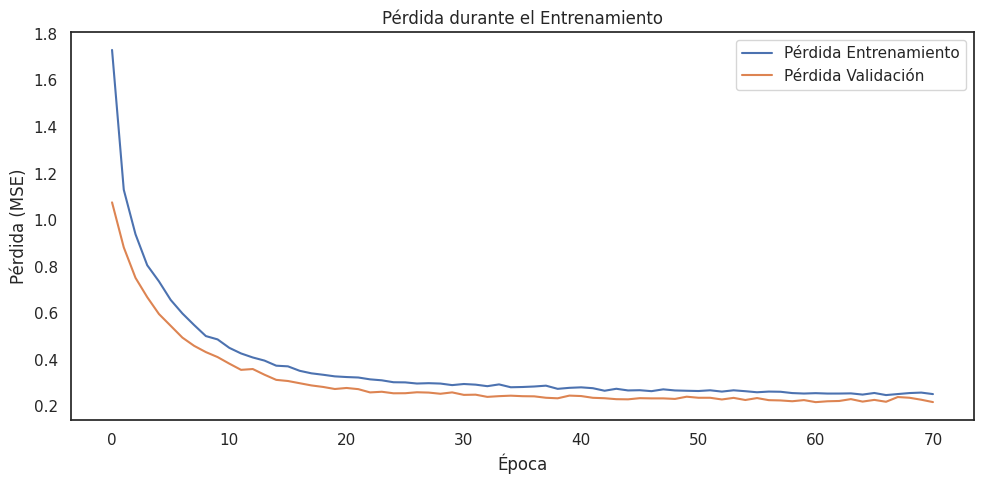

In [79]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.tight_layout()
plt.show()